Script to analyze the results on real datasets. This includes plotting the consensus tree and gene expression analysis.

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygraphviz as pgv
import seaborn as sns
import os
import json

from src_python.cell_tree import CellTree

In [212]:
study_num = "mm16" # mm16 mm34
np.random.seed(0)
n_rounds = 2
model = "sciterna"
use_summary_statistics = True

primary_cells = []

if study_num == "mm34":
    primary_cells = ["SRR6710302", "SRR6710303", "SRR6710304", "SRR6710305", "SRR6710306", "SRR6710307", "SRR6710308", "SRR6710309", "SRR6710310", "SRR6710311", "SRR6710312", "SRR6710313", "SRR6710314", "SRR6710315", "SRR6710316", "SRR6710317", "SRR6710318", "SRR6710319", "SRR6710320", "SRR6710321", "SRR6710322", "SRR6710323", "SRR6710324", "SRR6710325", "SRR6710326", "SRR6710327", "SRR6710328", "SRR6710329", "SRR6710330", "SRR6710331", "SRR6710332", "SRR6710333", "SRR6710334", "SRR6710335", "SRR6710336", "SRR6710337", "SRR6710338", "SRR6710339", "SRR6710340", "SRR6710341", "SRR6710342", "SRR6710343", "SRR6710344", "SRR6710345", "SRR6710346", "SRR6710347", "SRR6710348", "SRR6710349", "SRR6710350", "SRR6710351", "SRR6710352", "SRR6710353", "SRR6710354", "SRR6710355", "SRR6710356", "SRR6710357", "SRR6710358", "SRR6710359", "SRR6710360", "SRR6710361", "SRR6710362", "SRR6710363", "SRR6710364", "SRR6710365", "SRR6710366"]

if study_num == "mm16":
    primary_cells = ["SRR6710256", "SRR6710257", "SRR6710258", "SRR6710259", "SRR6710260", "SRR6710261", "SRR6710262", "SRR6710263", "SRR6710264", "SRR6710265", "SRR6710266", "SRR6710267", "SRR6710268", "SRR6710269", "SRR6710270", "SRR6710271", "SRR6710272", "SRR6710273", "SRR6710274", "SRR6710275", "SRR6710276", "SRR6710277", "SRR6710278"]

ref = np.array(pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv")))
cell_names = list(ref[:,0])
cell_indices = [cell_names.index(item) for item in primary_cells if item in cell_names]
n_cells = len(cell_names)

expression_counts = pd.read_csv(rf"../data/input_data/{study_num}/gene_expression_counts.csv", index_col=0)
normalized_counts = expression_counts.div(expression_counts.sum(axis=1), axis=0) * 1e5
expression_counts_scaled = np.log1p(normalized_counts)

Plot the trees

In [213]:
def plot_trees(inpath, test, plot_mutations=False, round=0):

    path_parent = os.path.join(inpath, f"{model}_parent_vec", f"{model}_parent_vec{round}{test}.txt")
    path_mut_loc = os.path.join(inpath, f"{model}_mutation_location", f"{model}_mutation_location{round}{test}.txt")
    path_selected = os.path.join(inpath, f"{model}_selected_loci", f"{model}_selected_loci{round}{test}.txt")

    parent_vec = np.loadtxt(path_parent, dtype=int)
    if os.path.exists(path_mut_loc) == False:
        mut_locs = []
        selected_mutations = []
    else:
        mut_locs = np.loadtxt(path_mut_loc, dtype=int)
        selected_mutations = np.loadtxt(path_selected, dtype=int)

    n_cells = int(((len(parent_vec)+1)/2))

    ct = CellTree(n_cells=n_cells, n_mut=len(selected_mutations))
    ct.use_parent_vec(parent_vec)

    if plot_mutations:
        ct.mut_loc = mut_locs
        graph = ct.to_graphviz()
        graph.render(os.path.join(inpath, f"{model}_ct_trees", f"ct_tree{round}{test}"), format='png', cleanup=True)

    ct.mut_loc = []
    graph_branches = ct.to_graphviz()
    for n in range(n_cells):
        if n in cell_indices:
            graph_branches.node(str(n), shape='circle', style='filled', color="red")
        else:
            graph_branches.node(str(n), shape='circle', style='filled', color="blue") # metastasis

    graph_branches.render(os.path.join(inpath, f"{model}_ct_trees", f"ct_tree{round}{test}_branches"), format='svg', cleanup=True)
    return graph_branches, parent_vec

model = "sciterna"
path = rf"../data/results/{study_num}/sciterna"
for j in range(2):
    sciterna_graph, sciterna_parent_vec = plot_trees(path, "r0", plot_mutations=True, round=f"_{j}")

model = "sclineager"
_,_ = plot_trees(rf"../data/results/{study_num}/{model}", "", plot_mutations=True, round = "")
model = "dendro"
_,_ = plot_trees(rf"../data/results/{study_num}/{model}", "", plot_mutations=True, round = "")

KeyboardInterrupt: 

In [190]:
def plot_consensus_tree(parent_vector, path, support_thresholds=None):

    n_cells = int((len(parent_vector) + 1) / 2)
    ct = CellTree(n_cells=n_cells, n_mut=0)
    ct.use_parent_vec(parent_vector)
    ct.mut_loc = []

    graph_branches = ct.to_graphviz()

    for node_id in range(len(parent_vector)):
        is_leaf = node_id < n_cells
        node_shape = 'circle'
        node_style = 'filled'

        if is_leaf:
            border_color = 'red' if node_id in cell_indices else 'blue'
            fillcolor = 'red' if node_id in cell_indices else 'blue'

            graph_branches.node(
                str(node_id),
                shape=node_shape,
                style=node_style,
                fillcolor=fillcolor,
                color=border_color,
                penwidth='4'
            )
        else:
            fillcolor = 'lightgrey'
            penwidth = 1

            max_support = np.max(list(support_thresholds.values()))
            if support_thresholds:
                support = support_thresholds.get(str(node_id), 0.0)

                penwidth = 20 * support/max_support

            graph_branches.node(
                str(node_id),
                shape=node_shape,
                style=node_style,
                fillcolor=fillcolor,
                color='black',
                penwidth=str(penwidth)
            )

    else:
        graph_branches.render(os.path.join(path, f"{model}_consensus_tree_{study_num}"), format='png', cleanup=True)
    return graph_branches, ct

path_bootstrap = rf"../data/results/{study_num}/sciterna_bootstrap"
consensus_parent_vec = np.loadtxt(os.path.join(path_bootstrap, "sciterna_consensus_parent_vec", "sciterna_parent_vec_1r.txt"), dtype=int)

with open(os.path.join(path_bootstrap, "sciterna_consensus_parent_vec", "sciterna_support_values_1r.json"), 'r') as f:
    support_values = json.load(f)

graph, ct_consensus = plot_consensus_tree(consensus_parent_vec, path_bootstrap, support_thresholds=support_values)

In [191]:
def get_node_positions(dot):
    """Get x-coordinates of all nodes from Graphviz layout."""
    A = pgv.AGraph(string=dot.source)
    A.layout(prog='dot')

    positions = {}
    for node in A.nodes():
        name = node.get_name()
        if not name.isdigit():
            continue
        pos = node.attr.get('pos')
        if pos:
            x, _ = map(float, pos.split(','))
            positions[int(name)] = x
    return positions

def dfs_left_to_right(graph, root, n_cells, positions):

    leaf_order = []

    def dfs(node):
        children = graph.get(node, [])
        # Sort children by x-position
        children_sorted = sorted(children, key=lambda x: positions.get(x, float('inf')))
        if not children:
            if node < n_cells:  # leaf node condition
                leaf_order.append(node)
            return
        for child in children_sorted:
            dfs(child)

    dfs(root)
    return leaf_order

# Build adjacency list from parent vector
def build_adj_list(parent_vec):
    from collections import defaultdict
    adj = defaultdict(list)
    for child, parent in enumerate(parent_vec):
        if parent != -1:
            adj[parent].append(child)
    return adj

positions = get_node_positions(graph)
adj_list = build_adj_list(consensus_parent_vec)
root = np.where(np.array(consensus_parent_vec) == -1)[0][0]

leaf_order = dfs_left_to_right(adj_list, root, n_cells, positions)

Gene expression analysis

<Figure size 4000x2000 with 0 Axes>

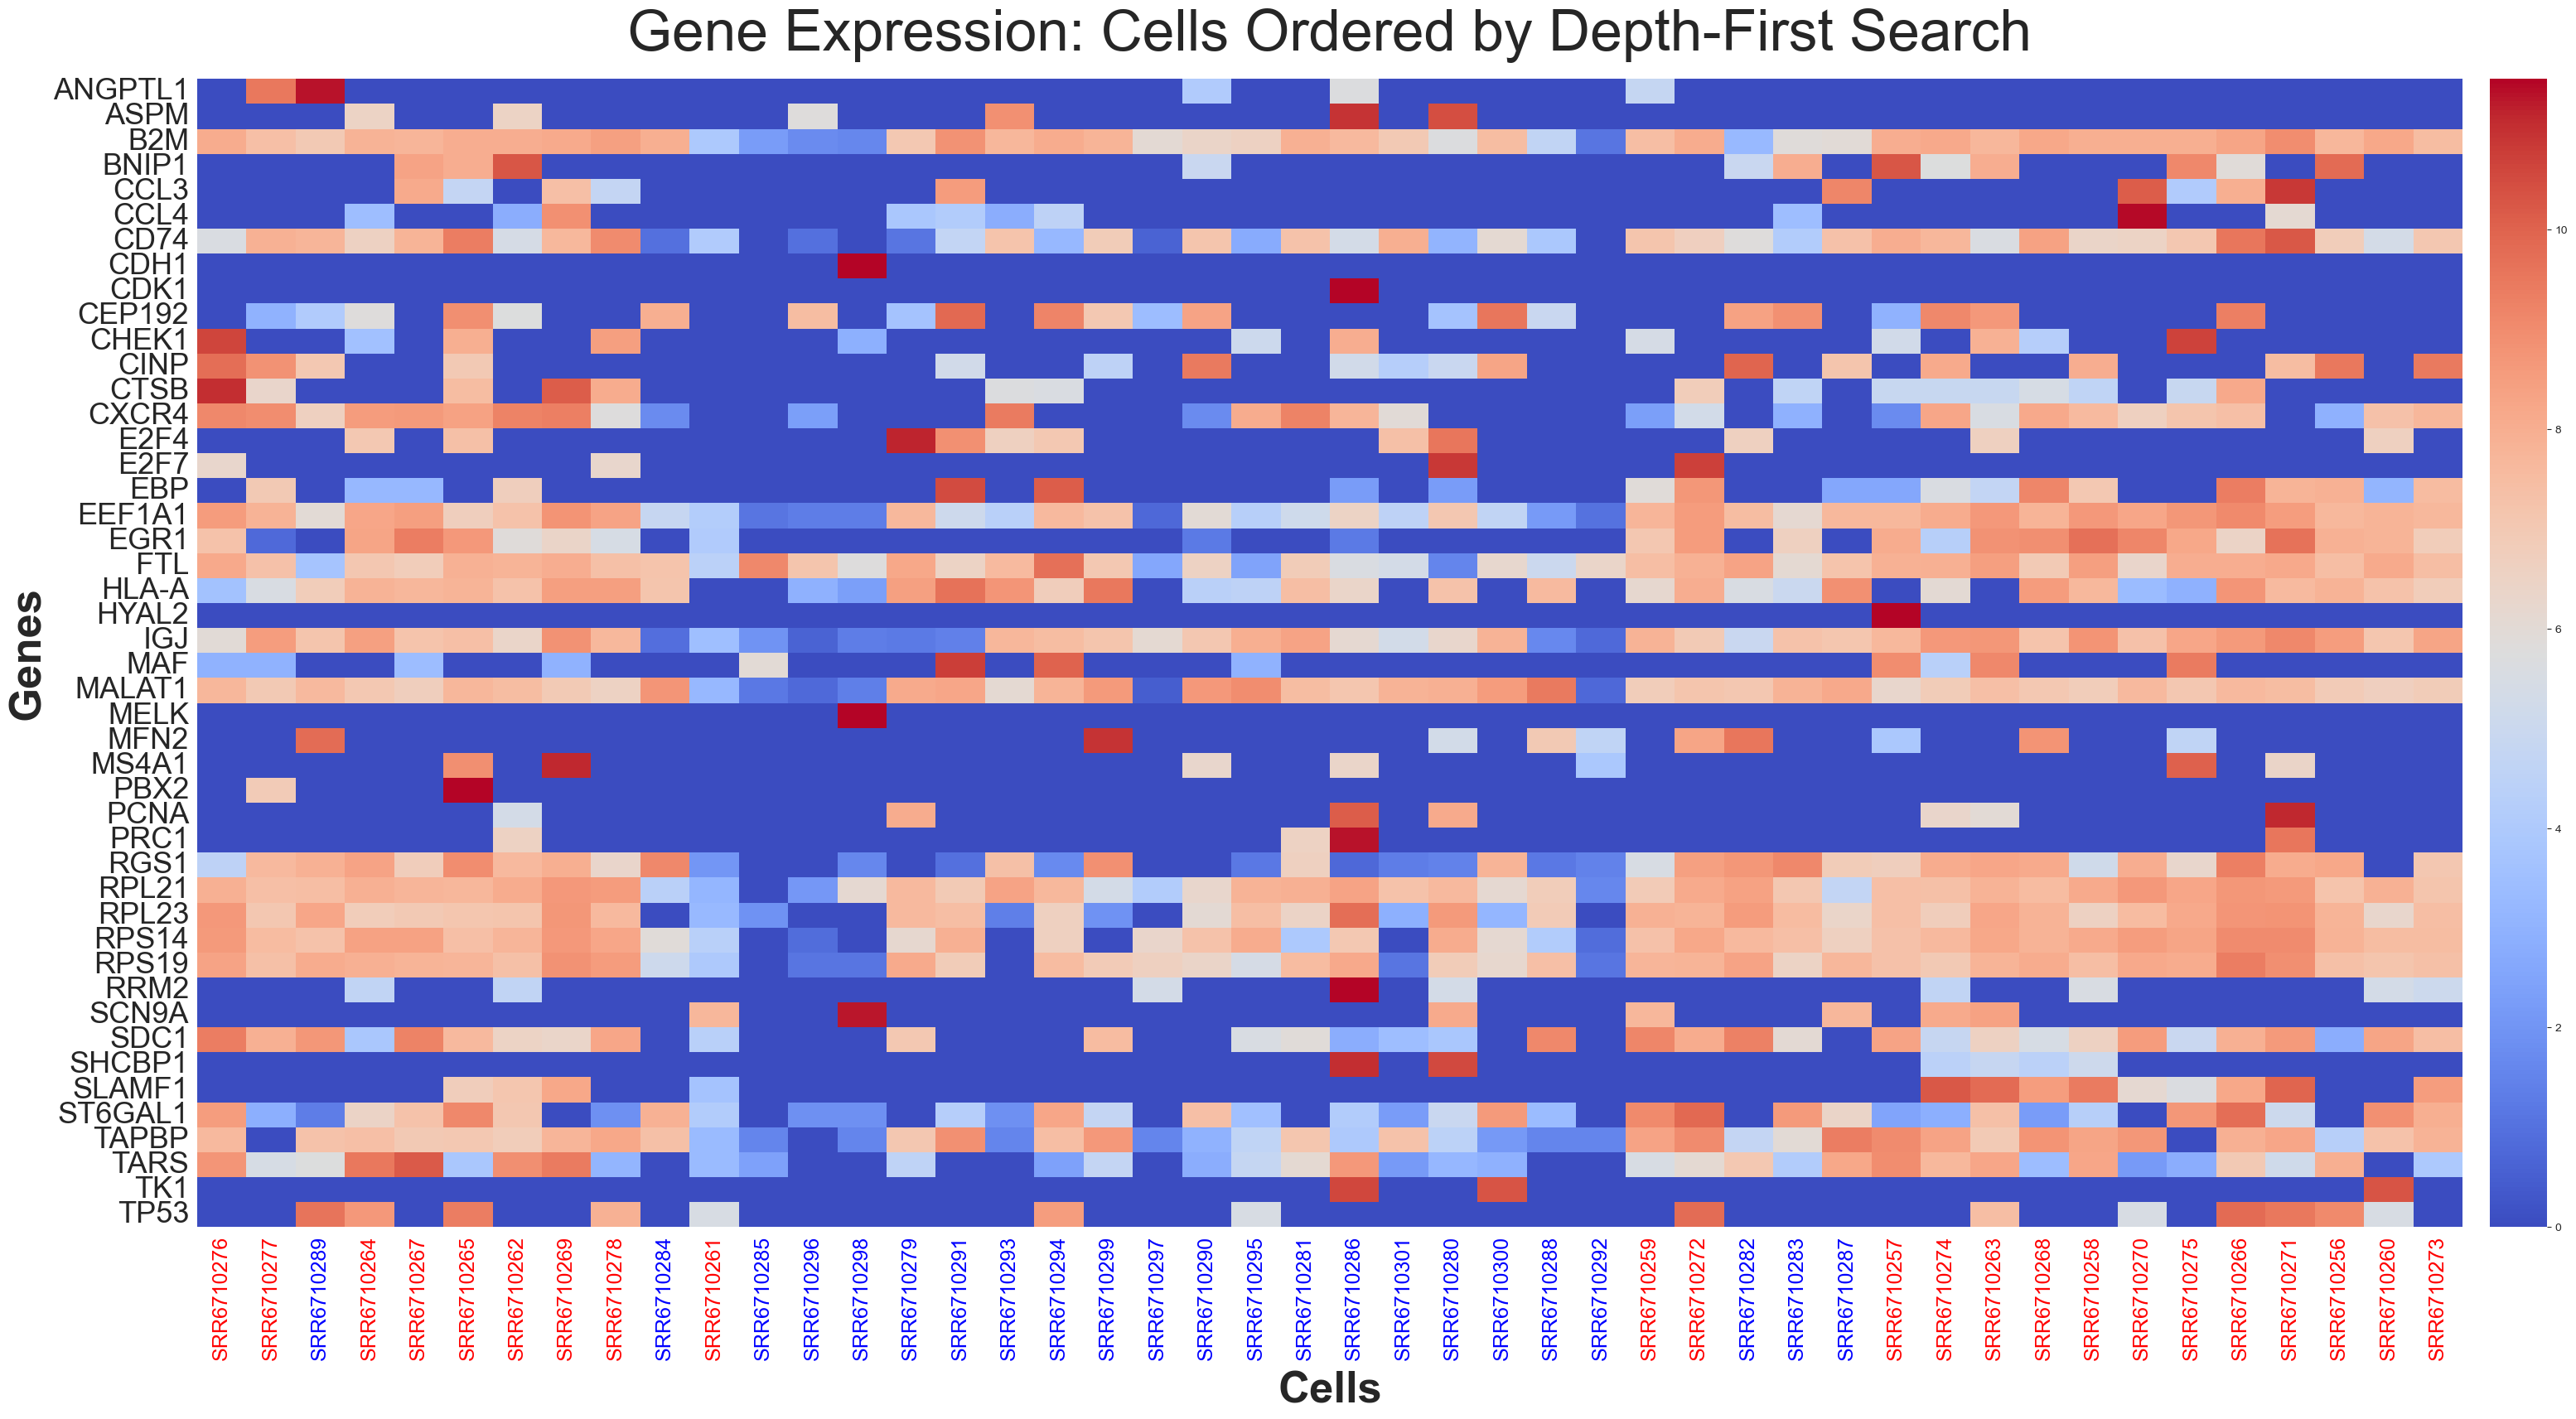

In [193]:
sorted_indices = leaf_order

plt.figure(figsize=(40, 20))

genes = top_expr_genes.index[:10]

if study_num[:2] == "mm":
    genes = ["IGJ", "CTSB", "EGR1", "FTL", "MALAT1", "RPL21", "SDC1", "SLAMF1", "CDH1", "ETV7", "CXCR4", "E2F4", "ANGPTL1", "HYAL2", "PBX2", "SCN9A", "BNIP1", "MFN2", "CEP192", "TARS", "E2F7", "MELK", "CHEK1", "EBP", "CINP", "PCNA", "ASPM", "CDK1", "MAF", "TP53", "MS4A1", "RGS1", "ST6GAL1", "HLA-A", "TAPBP", "CD74", "B2M", "CCL3", "CCL4", "RPS14","RPS19", "RPL23", "EEF1A1", "TK1", "RRM2","SHCBP1", "PRC1"]

chosen_genes = expression_counts_scaled[expression_counts_scaled.index.isin(genes)]
sorted_df = chosen_genes.iloc[:, sorted_indices]

col_colors = ['red' if val in cell_indices else 'blue' for val in sorted_indices]

plt.figure(figsize=(42, 18))
ax = sns.heatmap(sorted_df, cmap='coolwarm', cbar_kws={'pad': 0.01})

for n, tick_label in enumerate(ax.get_xticklabels()):
    tick_label.set_color(col_colors[n])
    tick_label.set_fontsize(18)

for tick_label in ax.get_yticklabels():
    tick_label.set_fontsize(26)
    tick_label.set_rotation(0)

plt.title("Gene Expression: Cells Ordered by Depth-First Search", fontsize=50, pad=25)
plt.ylabel("Genes", fontsize=38, fontweight='bold')
plt.xlabel("Cells", fontsize=38, fontweight='bold', labelpad=10)
plt.savefig(rf"../data/results/figures/gene_expression_{study_num}.svg", format="svg")
plt.show()

Estimating the model parameters

In [230]:
n_bootstrap = 1000
samples = ["MM16", "MM34"]
global_parameters = {}
mean_individual_overdispersions_h = {}
mean_individual_dropouts = {}

if not use_summary_statistics:
    for s in samples:
        path_bootstrap = rf"../data/results/{s.lower()}/sciterna_bootstrap"
        global_parameters[s] = []
        for i in range(n_bootstrap):
            for j in range(n_rounds-1, n_rounds):
                global_param = np.loadtxt(os.path.join(path_bootstrap, "sciterna_global_parameters", f"sciterna_global_parameters_{j}r{i}.txt")).tolist()
                global_parameters[s].append(global_param)
        global_parameters[s] = global_parameters[s] # Dropout, Overdispersion homozygous, Error Rate, Overdispersion heterozygous

        selected = np.loadtxt(os.path.join(path_bootstrap, "selected.txt"), delimiter=',', dtype=int)
        ref = pd.read_csv(os.path.join(f"../data/input_data/{s.lower()}", "ref.csv"))

        all_individual_overdispersions_h = np.full((n_bootstrap, ref.shape[1]), np.nan)
        all_individual_dropouts = np.full((n_bootstrap, ref.shape[1]), np.nan)

        for i in range(n_bootstrap):
            for j in range(n_rounds-1, n_rounds):
                selected_mutations = np.loadtxt(os.path.join(path_bootstrap, "sciterna_selected_loci", f"sciterna_selected_loci_{j}r{i}.txt"), dtype=int)
                individual_dropouts = np.loadtxt(os.path.join(path_bootstrap, "sciterna_individual_dropout_probs", f"sciterna_individual_dropout_probs_{j}r{i}.txt"))
                individual_overdispersions_h = np.loadtxt(os.path.join(path_bootstrap, "sciterna_individual_overdispersions_h", f"sciterna_individual_overdispersions_h_{j}r{i}.txt"))

                unique_mutations = np.unique(selected_mutations)
                for mut in unique_mutations:
                    indices = np.where(selected_mutations == mut)[0]
                    mean_dropout = np.mean(individual_dropouts[indices])
                    mean_overdispersion = np.mean(individual_overdispersions_h[indices])

                    all_individual_dropouts[i, mut] = mean_dropout
                    all_individual_overdispersions_h[i, mut] = mean_overdispersion

        global_parameters_sample = np.array(global_parameters[s])

        sufficient_data_columns_od = ~np.any(
            all_individual_overdispersions_h == global_parameters_sample[:, 3][:, np.newaxis], axis=0
        )

        sufficient_data_columns_dropout = ~np.any(
            all_individual_dropouts == global_parameters_sample[:, 0][:, np.newaxis], axis=0
        )
        mean_individual_overdispersions_h[s] = np.nanmean(all_individual_overdispersions_h[:, sufficient_data_columns_od], axis=0).tolist()
        mean_individual_dropouts = np.nanmean(all_individual_dropouts[:, sufficient_data_columns_dropout], axis=0).tolist()

else:
    with open("../data_summary/real_data/global_parameters.json", "r") as f:
        global_parameters = json.load(f)
    with open("../data_summary/real_data/mean_individual_overdispersions_h.json", "r") as f:
        mean_individual_overdispersions_h = json.load(f)
    with open("../data_summary/real_data/mean_individual_dropouts.json", "r") as f:
        mean_individual_dropouts = json.load(f)

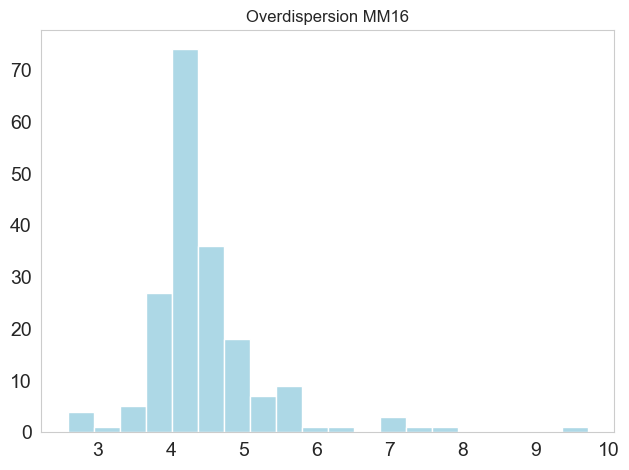

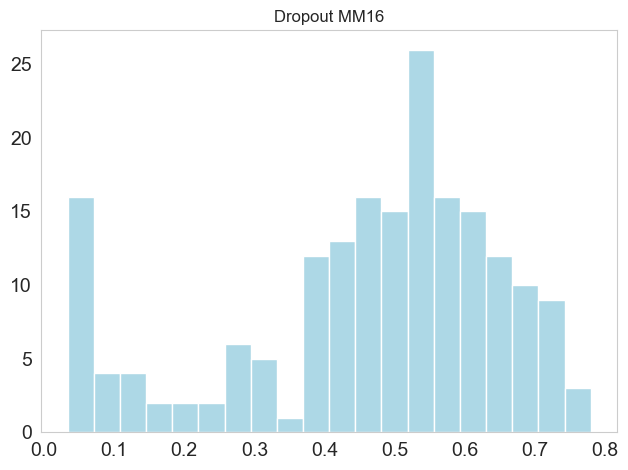

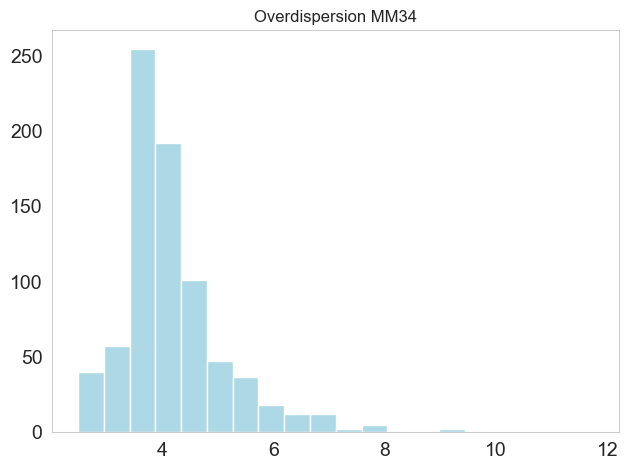

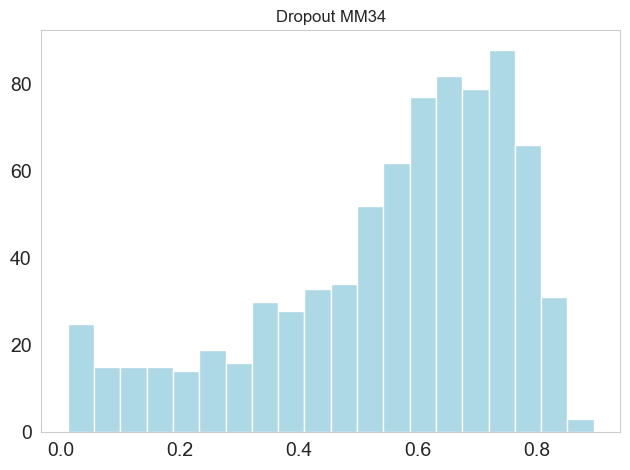

In [232]:
for s in samples:
    # get the individual parameters, that were optimized for each SNV, instead of using the global parameter value

    mean_dropouts = mean_individual_dropouts[s]
    mean_overdispersions = mean_individual_overdispersions_h[s]
    path_bootstrap = rf"../data/results/{s}/sciterna_bootstrap"

    plt.hist(mean_overdispersions, bins=20, color='lightblue')
    plt.grid(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"Overdispersion {s}")
    plt.tight_layout()
    # plt.savefig(os.path.join(path_bootstrap, "overdispersion_histogram.svg"), format="svg")
    plt.show()

    plt.hist(mean_dropouts, bins=20, color='lightblue')
    plt.grid(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"Dropout {s}")
    plt.tight_layout()
    # plt.savefig(os.path.join(path_bootstrap, "dropout_histogram.svg"), format="svg")
    plt.show()

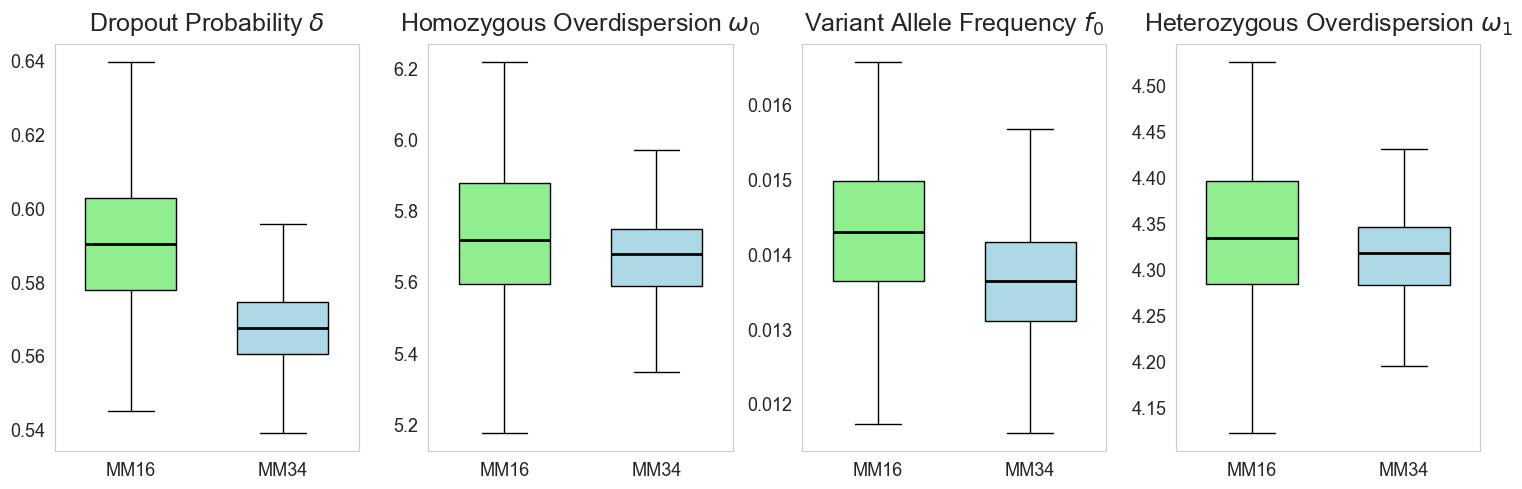

In [228]:
param_names = [r"Dropout Probability $\delta$", r"Homozygous Overdispersion $\omega_\mathrm{0}$", r"Variant Allele Frequency $f_\mathrm{0}$", r"Heterozygous Overdispersion $\omega_\mathrm{1}$"]

for s in samples:
    global_parameters[s] = np.array(global_parameters[s])

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
box_colors = ['lightgreen', 'lightblue', 'lightcoral', 'khaki']

for idx, param_name in enumerate(param_names):
    # Collect values for this parameter across all samples
    data = [global_parameters[s][:, idx] for s in samples]
    bplot = axes[idx].boxplot(data, patch_artist=True, labels=samples, showfliers=False, widths=0.6)

    # Color each box
    for patch, color in zip(bplot['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')

    for median in bplot['medians']:
        median.set_color('black')
        median.set_linewidth(2)

    axes[idx].set_title(param_name, fontsize=18, pad=10)
    axes[idx].set_ylabel(f"", fontsize=14)
    axes[idx].tick_params(axis='x', labelsize=13)
    axes[idx].tick_params(axis='y', labelsize=13)
    axes[idx].grid(False)

plt.tight_layout()
# plt.savefig(r"..\data\results\figures\global_parameters.pdf", format="pdf")
plt.show()

Additional analysis:
Visualizing the input and predicted variant allele frequencies

In [199]:
selected_loci = np.loadtxt(rf"../data/results/{study_num}/sciterna_bootstrap/selected.txt", dtype=int)

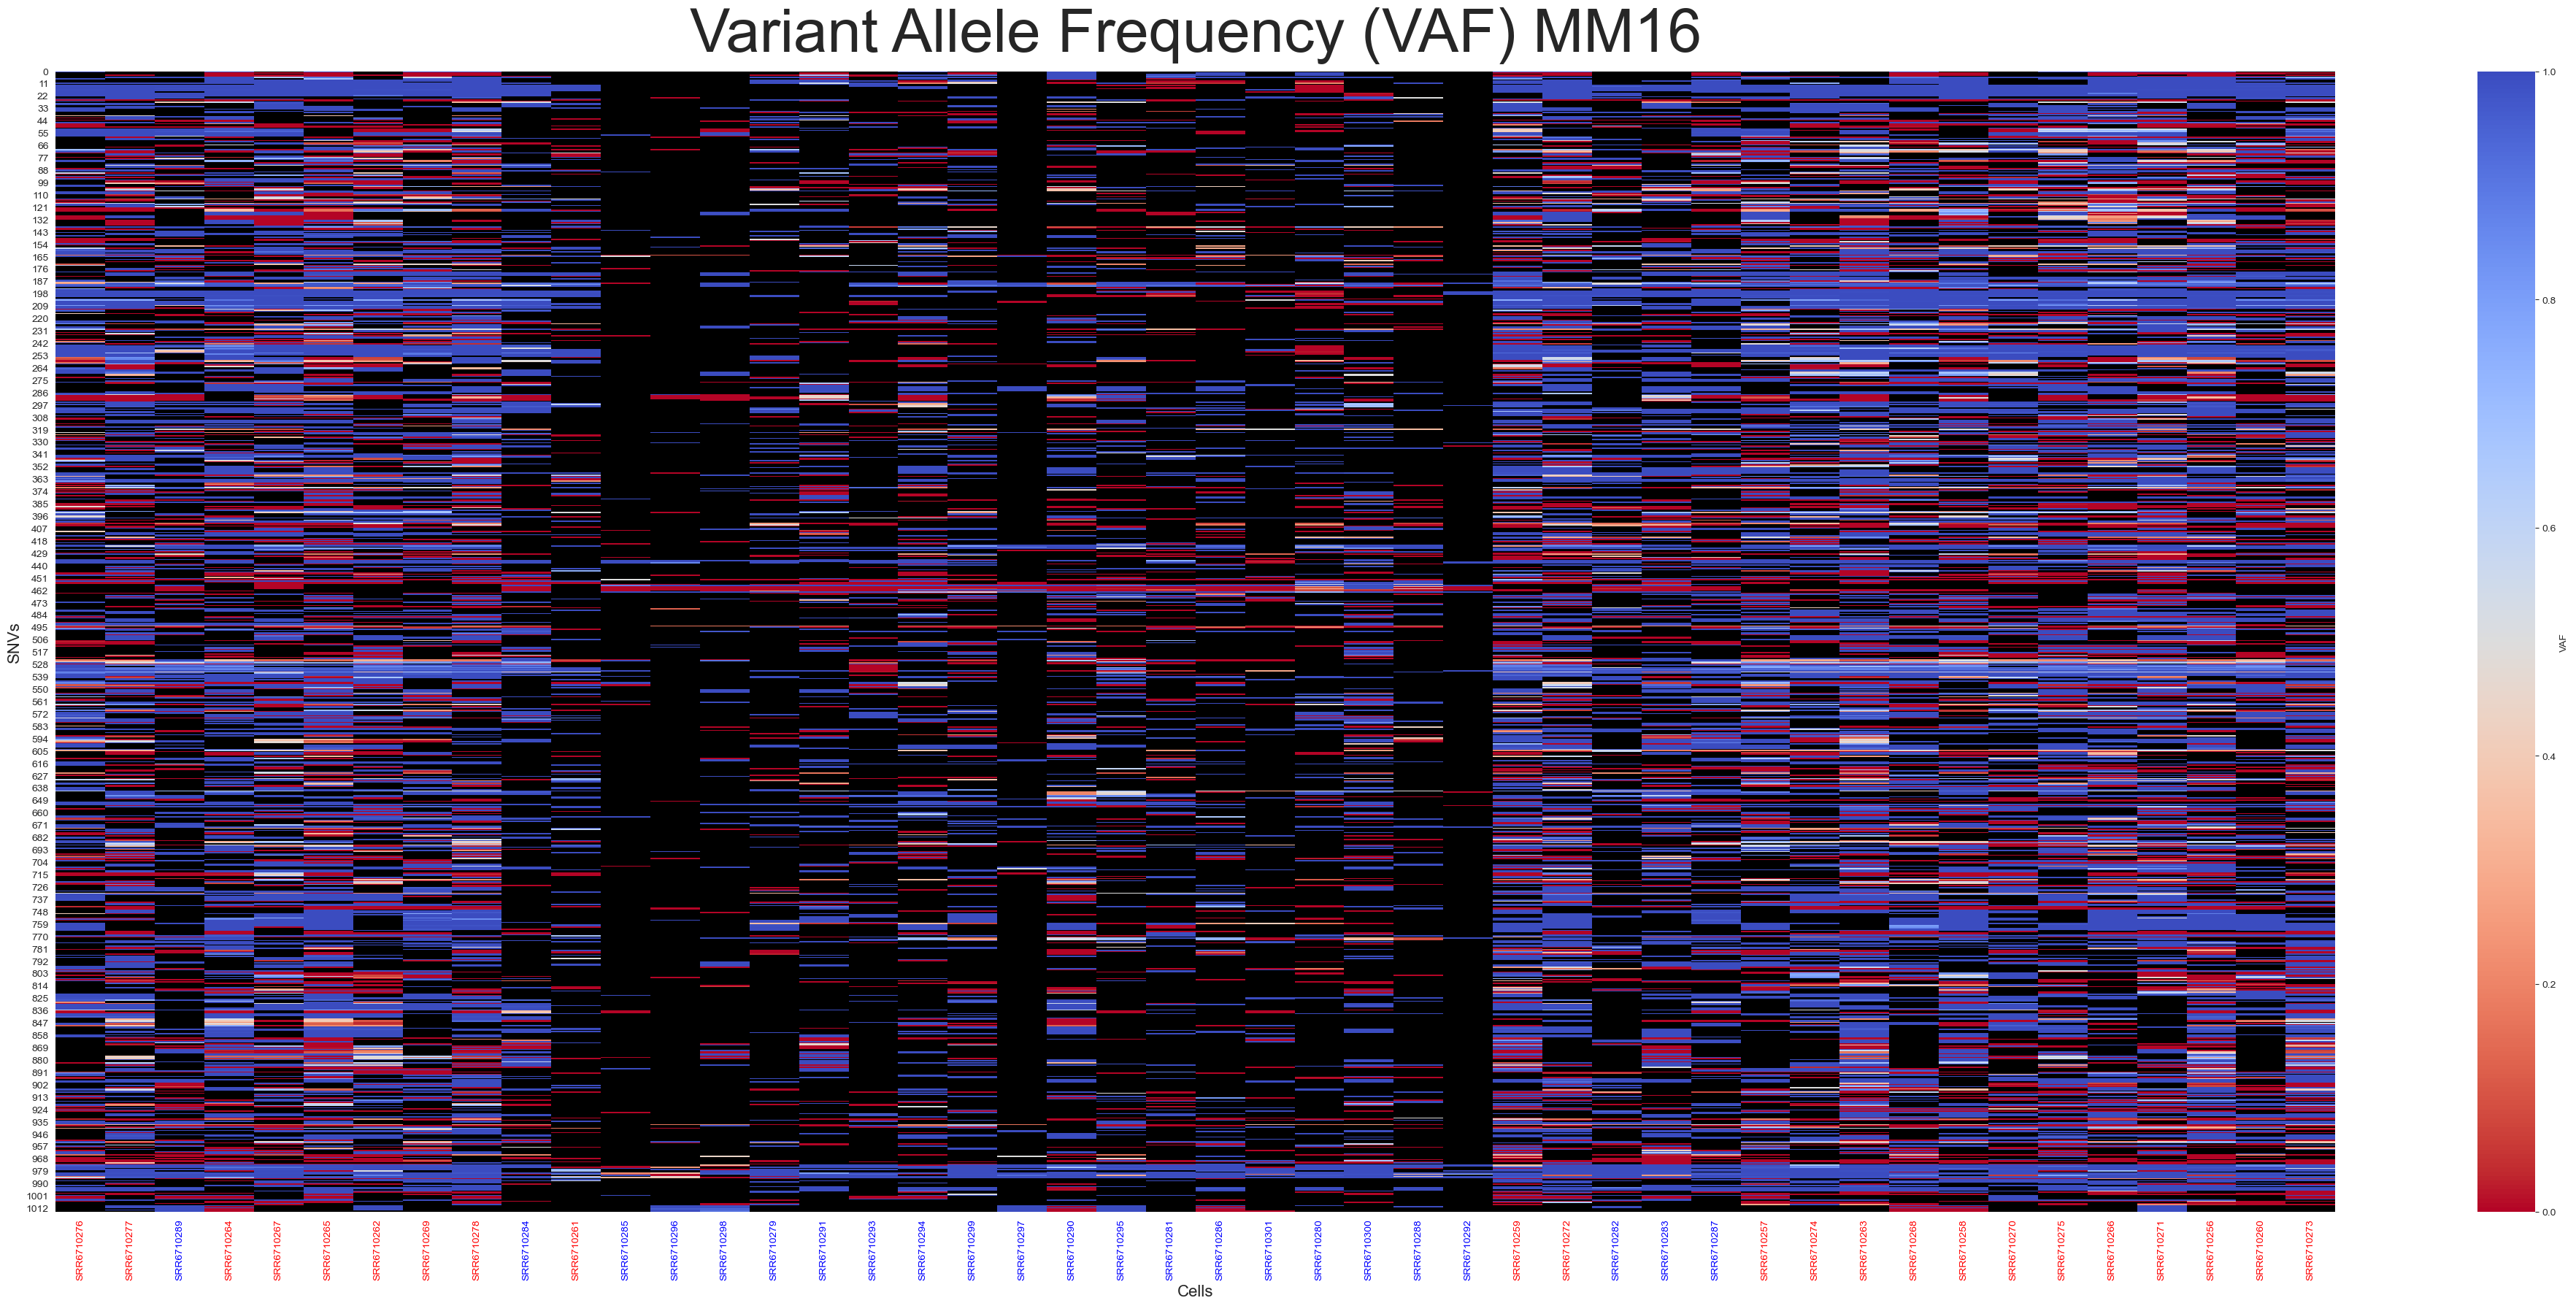

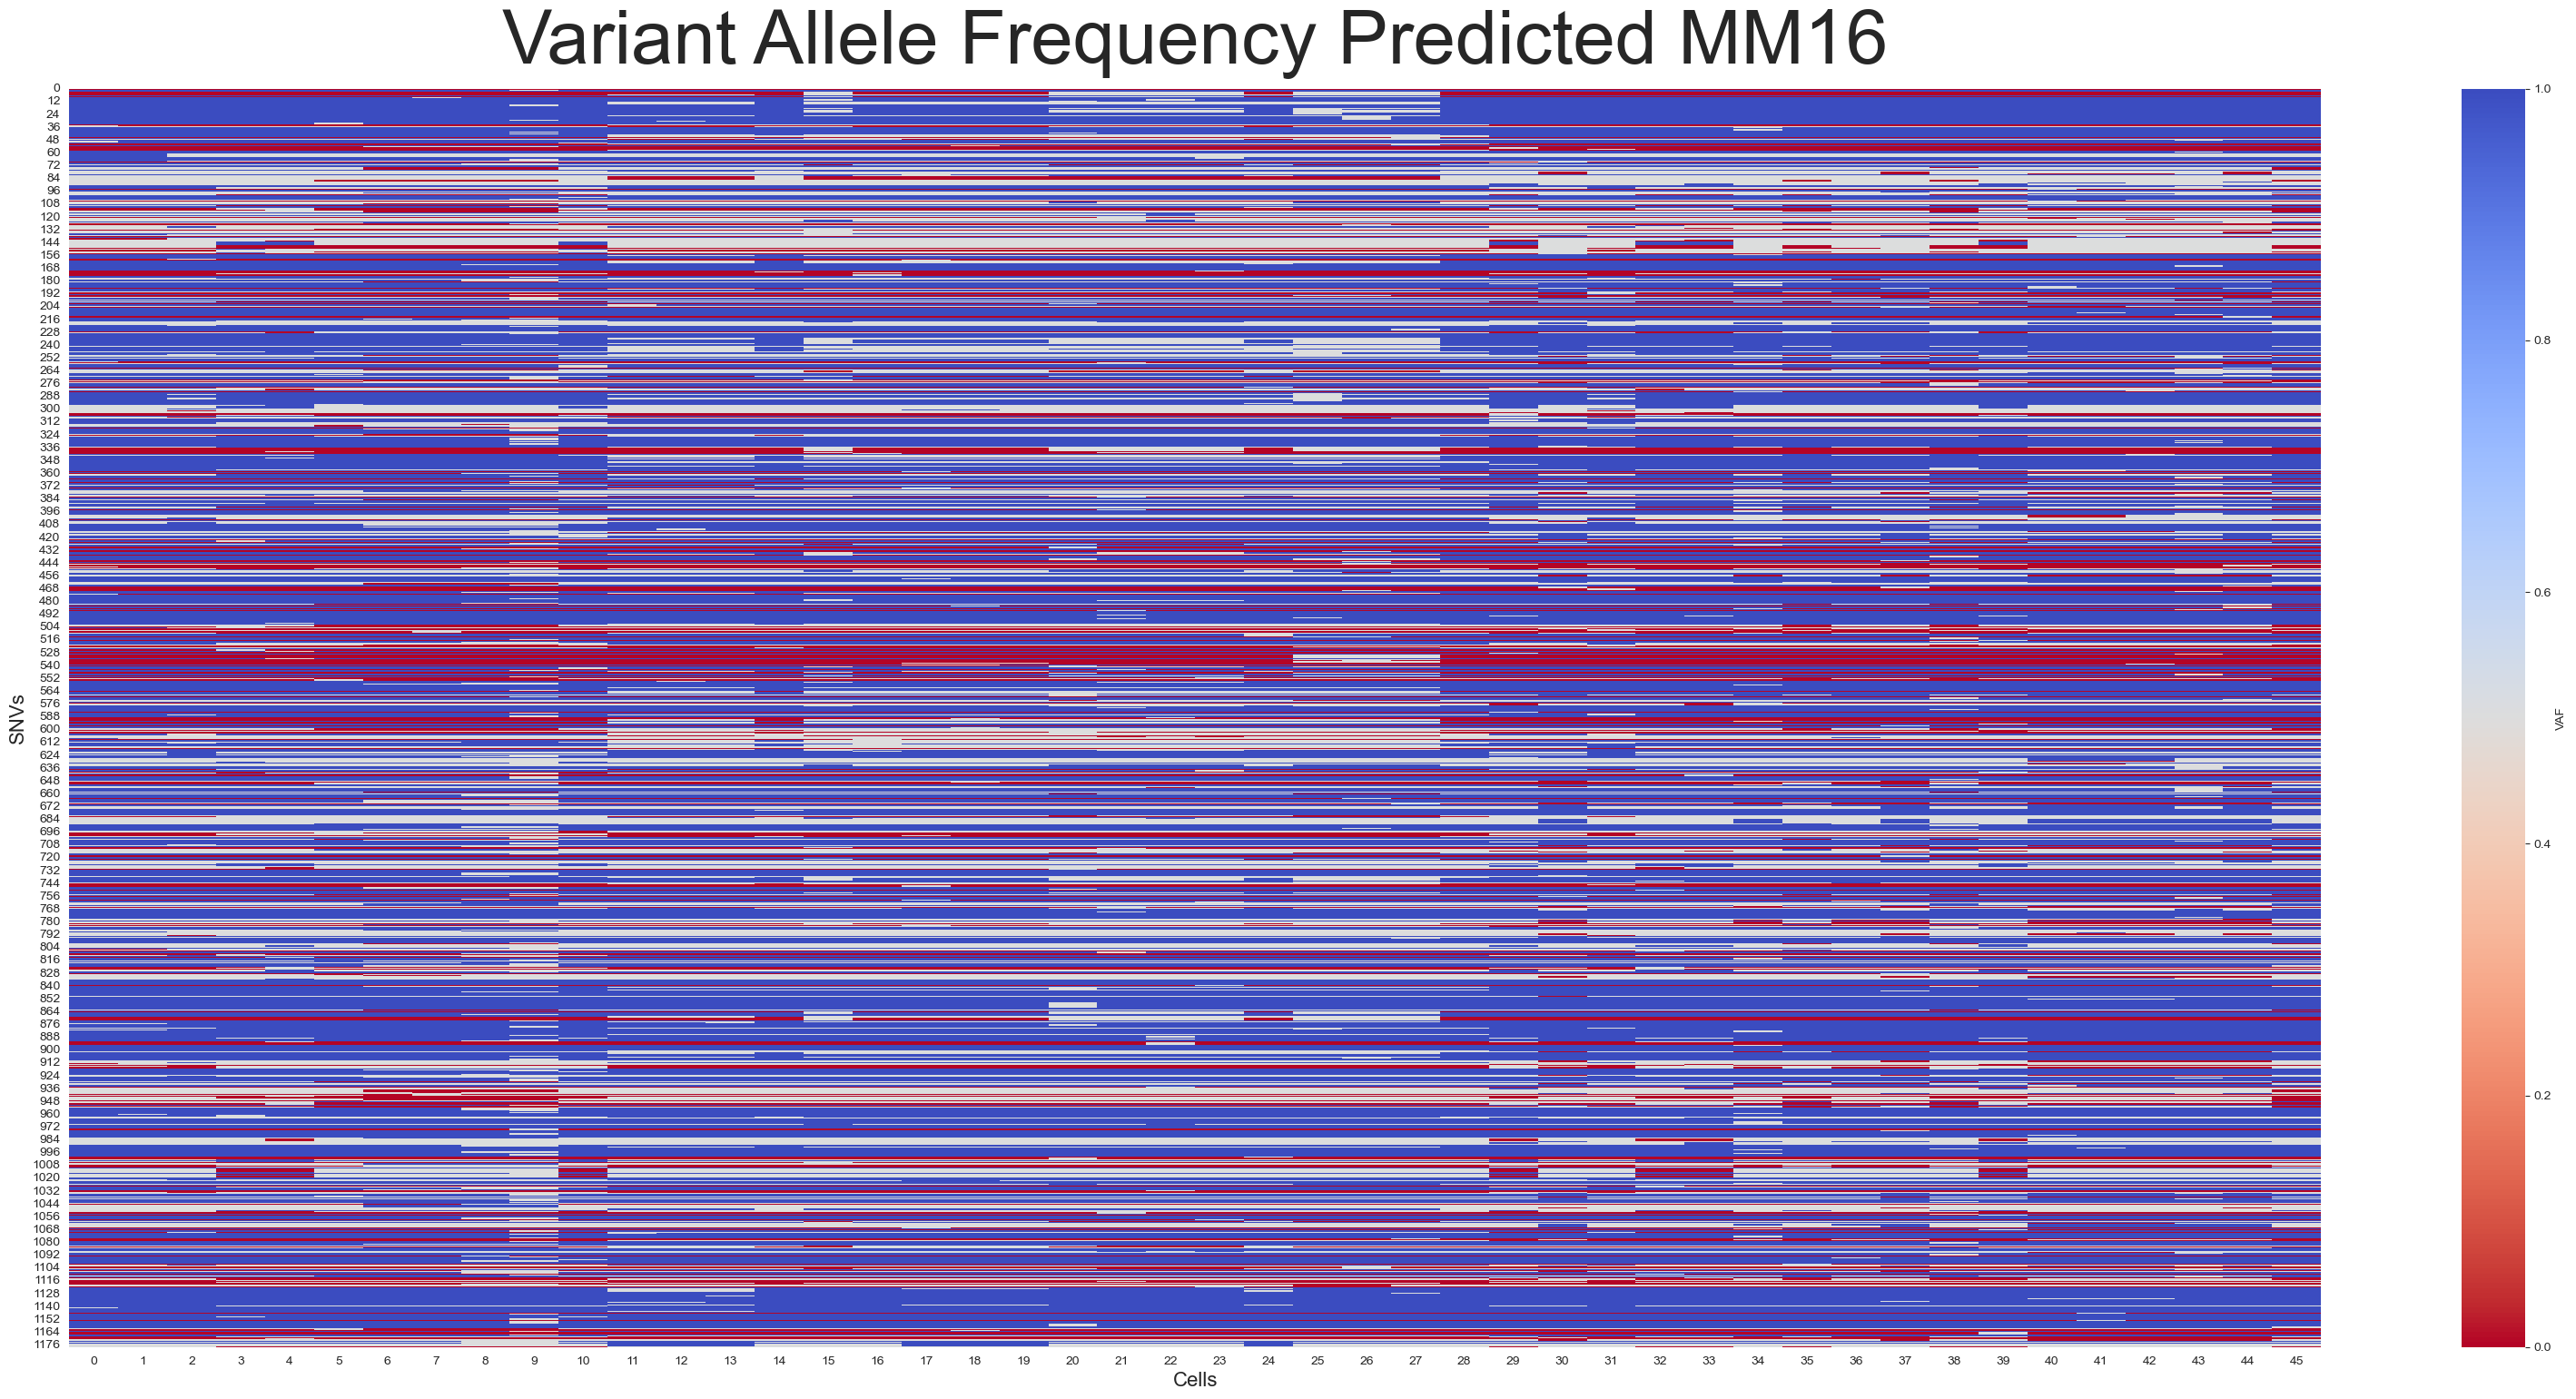

In [200]:
ref = np.array(pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv")))[:, 1:].astype(int)
alt = np.array(pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "alt.csv")))[:, 1:].astype(int)
genotype_predicted = np.loadtxt(os.path.join(path, "sciterna_genotype", "sciterna_genotype_1r0.txt"), dtype= str)[leaf_order].T

with np.errstate(divide='ignore', invalid='ignore'):
    vaf = alt[:,selected_loci] / (ref[:,selected_loci] + alt[:,selected_loci])

vaf = vaf[leaf_order].T
base_cmap = plt.get_cmap("coolwarm_r")  # Or 'coolwarm', 'RdYlBu'
cmap_with_nan = base_cmap
cmap_with_nan.set_bad(color='black')

plt.figure(figsize=(40, 18))
ax = sns.heatmap(
    vaf,
    cmap=cmap_with_nan,
    vmin=0,
    vmax=1,
    cbar_kws={"label": "VAF"}
)
plt.title(f"Variant Allele Frequency (VAF) {study_num.upper()}", fontsize=60, pad=20)
plt.ylabel("SNVs", fontsize=16)
plt.xlabel("Cells", fontsize=16)

# Set x-axis tick label colors
ax.set_xticks(np.arange(len(leaf_order)) + 0.5)
ax.set_xticklabels(sorted_df.columns, rotation=90)
for n, tick_label in enumerate(ax.get_xticklabels()):
    tick_label.set_color(col_colors[n])

plt.tight_layout()
# plt.savefig(rf"../data/results/{study_num}/sciterna_bootstrap/vaf.png", format="png")
plt.show()

mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
genotype_predicted = vectorized_map(genotype_predicted)[:]

plt.figure(figsize=(40, 18))
ax = sns.heatmap(
    genotype_predicted,
    cmap=cmap_with_nan,
    vmin=0,
    vmax=1,
    cbar_kws={"label": "VAF"}
)
plt.title(f"Variant Allele Frequency Predicted {study_num.upper()}", fontsize=60, pad=20)
plt.ylabel("SNVs", fontsize=16)
plt.xlabel("Cells", fontsize=16)
plt.show()

Finally we aim to find the genes with the most mutations

In [201]:
# with open("../data/input_data/gencode.v21.annotation.gtf", 'r') as file:
#     for line in file:
#         if line.startswith("#"):
#                 continue
#         fields = line.strip().split('\t')
#         if fields[2] == 'gene':
#             attributes = {key_value.split(' ')[0]: key_value.split(' ')[1].strip('"') for key_value in
#                           fields[8].split('; ') if key_value}
#             gene_names.append([fields[0], fields[3], fields[4], attributes["gene_name"]])
#
# df = pd.DataFrame(gene_names, columns=['chromosome', 'start', 'end', 'gene'])
# df['start'] = df['start'].astype(int)
# df['end'] = df['end'].astype(int)
# df.to_csv("../data/input_data/mm34/gene_positions.csv", index=False)

def convert_location_to_gene(locs):

    loc_to_gene = []

    df = pd.read_csv("../data/input_data/mm34/gene_positions.csv", index_col=False)
    for location in locs:
        chrom, pos = location.split(":")[0], location.split(":")[1]
        pos = int(pos)
        matching_rows = df[(df['chromosome'] == chrom) & (df['start'] <= pos) & (df['end'] >= pos)]
        matching_genes = matching_rows['gene'].tolist()
        loc_to_gene.append(matching_genes)

    return loc_to_gene

In [202]:
ref = pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv"))
selected_loci_pos = ref.columns[selected_loci][1:]
selected_genes = convert_location_to_gene(selected_loci_pos)

In [203]:
genes = []
for s in selected_genes:
    genes.extend(s)
gens, cnt = np.unique(genes, return_counts=True)

print(cnt[np.argsort(cnt)][-30:])
print(gens[np.argsort(cnt)][-30:])

[ 5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  7  7  7  8  8  8  8
  9 10 13 14 18 47]
['IGHV4-34' 'RP5-857K21.4' 'VAMP8' 'SERPINB9' 'CD38' 'MCTP2' 'MALAT1'
 'ELL' 'COA1' 'PHACTR1' 'IFRD1' 'IGHV1-2' 'UBE2H' 'HLA-B' 'HCLS1' 'IGKC'
 'HLA-C' 'SLC35F2' 'SSR3' 'ANKRD28' 'NAMPT' 'IGHG3' 'MIR29B1' 'HLA-A'
 'IGHM' 'CNTN5' 'FNDC3B' 'AC016831.7' 'IGHG1' 'LINC-PINT']
